In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score,f1_score
from keras import callbacks
import pandas as pd

In [2]:
df = pd.read_csv("./weatherAUS.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

<AxesSubplot:xlabel='RainTomorrow', ylabel='count'>

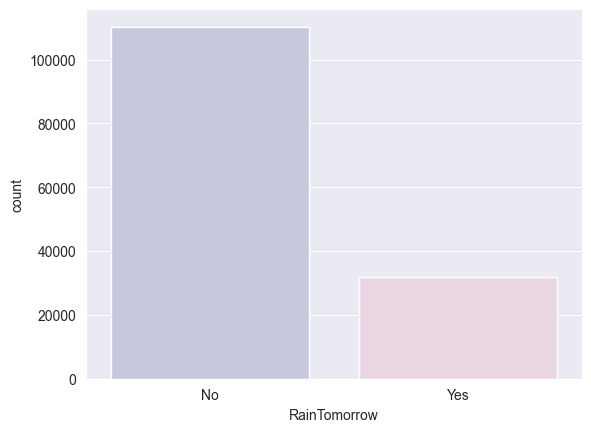

In [4]:
#first of all let us evaluate the target and find out if our data is imbalanced or not
cols = ["#C2C4E2", "#EED4E5"]
sns.countplot(x=df["RainTomorrow"], palette=cols)

C:\Users\hieul\AppData\Local\Temp\ipykernel_36044\487155910.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data = df.corr()["RainTomorrow"].sort_values(ascending=False)


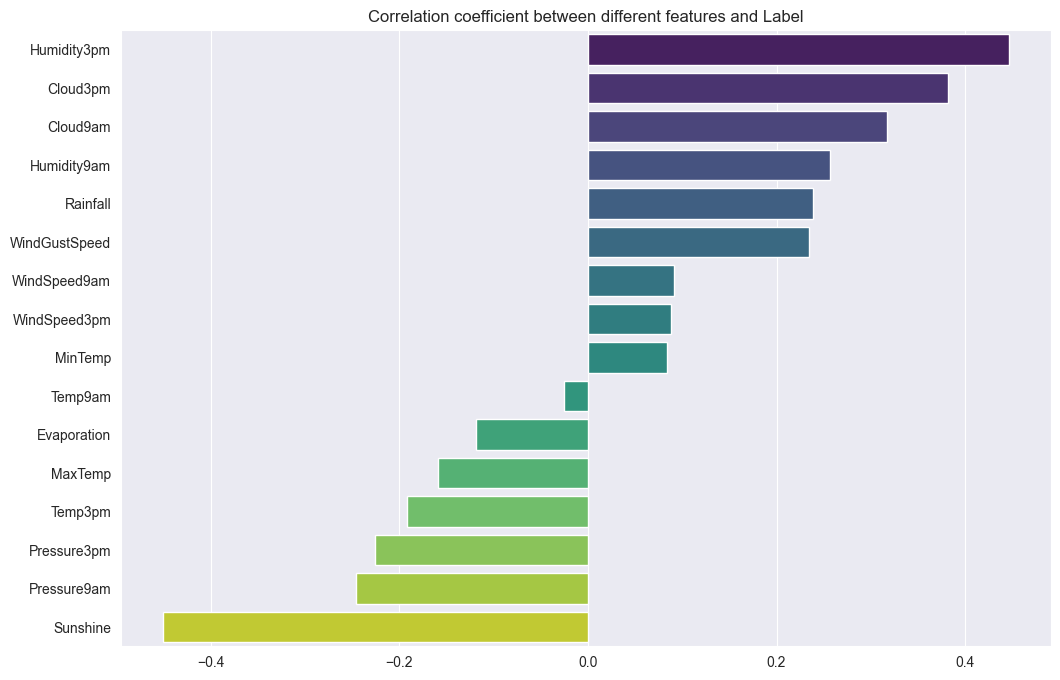

In [10]:
# Correlation amongst numeric attributes
df.RainTomorrow.replace(["Yes", "No"], [1, 0], inplace=True)

plt.figure(figsize=(12, 8))
data = df.corr()["RainTomorrow"].sort_values(ascending=False)
indices = data.index
labels = []
corr = []
for i in range(1, len(indices)):
    labels.append(indices[i])
    corr.append(data[i])
sns.barplot(x=corr, y=labels, palette='viridis')
plt.title('Correlation coefficient between different features and Label')
plt.show()

In [11]:
# Run the code to save predictions in the format used for competition scoring
output = pd.DataFrame({'labels': labels,
                       'corr': corr})
output.to_csv('corre.csv', index=False)

In [12]:
#Parsing datetime
#exploring the length of date objects
lengths = df["Date"].str.len()
lengths.value_counts()

10    145460
Name: Date, dtype: int64

In [13]:
import numpy as np

np.random.seed(0)

#There don't seem to be any error in dates so parsing values into datetime
df['Date'] = pd.to_datetime(df["Date"])
#Creating a collumn of year
df['year'] = df.Date.dt.year


# function to encode datetime into cyclic parameters.
#As I am planning to use this data in a neural network I prefer the months and days in a cyclic continuous feature.

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
    return data


df['month'] = df.Date.dt.month
data = encode(df, 'month', 12)

data['day'] = data.Date.dt.day
data = encode(data, 'day', 31)

data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,21.8,No,0.0,2008,12,-2.449294e-16,1.0,1,0.201299,0.979530
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,24.3,No,0.0,2008,12,-2.449294e-16,1.0,2,0.394356,0.918958
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,23.2,No,0.0,2008,12,-2.449294e-16,1.0,3,0.571268,0.820763
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,26.5,No,0.0,2008,12,-2.449294e-16,1.0,4,0.724793,0.688967
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,29.7,No,0.0,2008,12,-2.449294e-16,1.0,5,0.848644,0.528964


Text(0.5, 0, 'Days In Year')

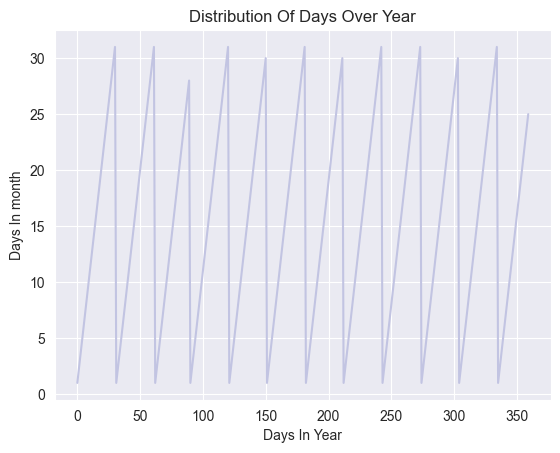

In [14]:
# roughly a year's span section
section = data[:360]
tm = section["day"].plot(color="#C2C4E2")
tm.set_title("Distribution Of Days Over Year")
tm.set_ylabel("Days In month")
tm.set_xlabel("Days In Year")

Text(0.5, 0, 'Sine Encoded Months')

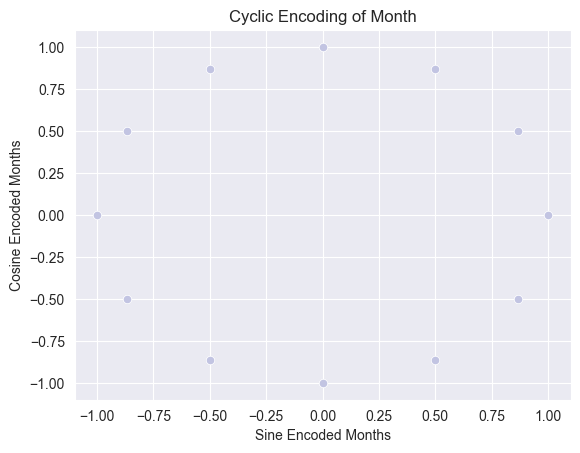

In [15]:
cyclic_month = sns.scatterplot(x="month_sin", y="month_cos", data=data, color="#C2C4E2")
cyclic_month.set_title("Cyclic Encoding of Month")
cyclic_month.set_ylabel("Cosine Encoded Months")
cyclic_month.set_xlabel("Sine Encoded Months")

Text(0.5, 0, 'Sine Encoded Day')

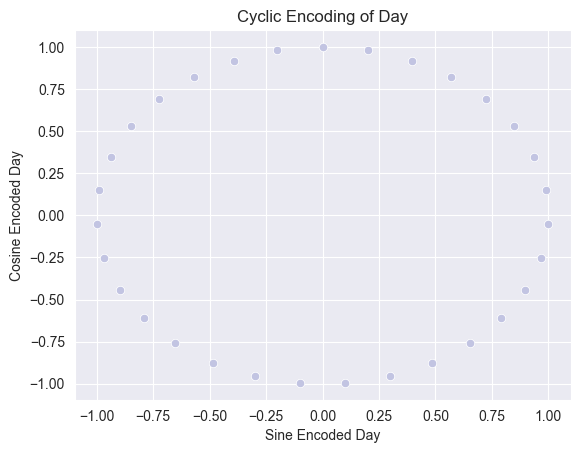

In [16]:
cyclic_day = sns.scatterplot(x='day_sin', y='day_cos', data=data, color="#C2C4E2")
cyclic_day.set_title("Cyclic Encoding of Day")
cyclic_day.set_ylabel("Cosine Encoded Day")
cyclic_day.set_xlabel("Sine Encoded Day")

In [20]:
# Get list of categorical variables
s = (data.dtypes == "object")
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


In [21]:
# Missing values in categorical variables

for i in object_cols:
    print(i, data[i].isnull().sum())

Location 0
WindGustDir 0
WindDir9am 0
WindDir3pm 0
RainToday 0


In [22]:
# Filling missing values with mode of the column in value

for i in object_cols:
    data[i].fillna(data[i].mode()[0], inplace=True)

In [23]:
# Get list of numeric variables
t = (data.dtypes == "float64")
num_cols = list(t[t].index)

print("Numeric variables:")
print(num_cols)

Numeric variables:
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainTomorrow', 'month_sin', 'month_cos', 'day_sin', 'day_cos']


In [24]:
# Missing values in numeric variables

for i in num_cols:
    print(i, data[i].isnull().sum())

MinTemp 0
MaxTemp 0
Rainfall 0
Evaporation 0
Sunshine 0
WindGustSpeed 0
WindSpeed9am 0
WindSpeed3pm 0
Humidity9am 0
Humidity3pm 0
Pressure9am 0
Pressure3pm 0
Cloud9am 0
Cloud3pm 0
Temp9am 0
Temp3pm 0
RainTomorrow 0
month_sin 0
month_cos 0
day_sin 0
day_cos 0


In [25]:
# Filling missing values with median of the column in value

for i in num_cols:
    data[i].fillna(data[i].median(), inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56420 entries, 6049 to 142302
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           56420 non-null  datetime64[ns]
 1   Location       56420 non-null  object        
 2   MinTemp        56420 non-null  float64       
 3   MaxTemp        56420 non-null  float64       
 4   Rainfall       56420 non-null  float64       
 5   Evaporation    56420 non-null  float64       
 6   Sunshine       56420 non-null  float64       
 7   WindGustDir    56420 non-null  object        
 8   WindGustSpeed  56420 non-null  float64       
 9   WindDir9am     56420 non-null  object        
 10  WindDir3pm     56420 non-null  object        
 11  WindSpeed9am   56420 non-null  float64       
 12  WindSpeed3pm   56420 non-null  float64       
 13  Humidity9am    56420 non-null  float64       
 14  Humidity3pm    56420 non-null  float64       
 15  Pressure9am    

In [26]:
# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for i in object_cols:
    data[i] = label_encoder.fit_transform(data[i])

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56420 entries, 6049 to 142302
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           56420 non-null  datetime64[ns]
 1   Location       56420 non-null  int32         
 2   MinTemp        56420 non-null  float64       
 3   MaxTemp        56420 non-null  float64       
 4   Rainfall       56420 non-null  float64       
 5   Evaporation    56420 non-null  float64       
 6   Sunshine       56420 non-null  float64       
 7   WindGustDir    56420 non-null  int32         
 8   WindGustSpeed  56420 non-null  float64       
 9   WindDir9am     56420 non-null  int32         
 10  WindDir3pm     56420 non-null  int32         
 11  WindSpeed9am   56420 non-null  float64       
 12  WindSpeed3pm   56420 non-null  float64       
 13  Humidity9am    56420 non-null  float64       
 14  Humidity3pm    56420 non-null  float64       
 15  Pressure9am    

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp3pm,RainToday,RainTomorrow,year,month,month_sin,month_cos,day,day_sin,day_cos
6049,2009-01-01,4,17.9,35.2,0.0,12.0,12.3,11,48.0,1,...,33.4,0,0.0,2009,1,0.5,0.866025,1,0.201299,0.979530
6050,2009-01-02,4,18.4,28.9,0.0,14.8,13.0,8,37.0,10,...,27.0,0,0.0,2009,1,0.5,0.866025,2,0.394356,0.918958
6052,2009-01-04,4,19.4,37.6,0.0,10.8,10.6,5,46.0,5,...,34.9,0,0.0,2009,1,0.5,0.866025,4,0.724793,0.688967
6053,2009-01-05,4,21.9,38.4,0.0,11.4,12.2,14,31.0,14,...,35.6,0,0.0,2009,1,0.5,0.866025,5,0.848644,0.528964
6054,2009-01-06,4,24.2,41.0,0.0,11.2,8.4,14,35.0,7,...,37.6,0,0.0,2009,1,0.5,0.866025,6,0.937752,0.347305


In [27]:
# Prepairing attributes of scale data

features = data.drop(['RainTomorrow', 'Date', 'day', 'month'], axis=1)  # dropping target and extra columns

target = data['RainTomorrow']

#Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = preprocessing.StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names)

features.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,56420.0,8.060038e-17,1.000009,-1.729701,-0.770950,0.050836,0.872623,1.694409
MinTemp,56420.0,-7.254034e-17,1.000009,-3.142579,-0.758150,-0.041263,0.769131,2.795116
MaxTemp,56420.0,3.707618e-16,1.000009,-2.886289,-0.791782,-0.045793,0.786271,3.425924
Rainfall,56420.0,-3.425516e-17,1.000009,-0.303702,-0.303702,-0.303702,-0.218168,29.091459
Evaporation,56420.0,-3.627017e-17,1.000009,-1.488843,-0.731318,-0.136121,0.513186,20.479371
Sunshine,56420.0,-3.385216e-16,1.000009,-2.058376,-0.727924,0.230002,0.788792,1.799936
WindGustDir,56420.0,2.015010e-17,1.000009,-1.562005,-0.935996,0.107353,0.942032,1.568041
WindGustSpeed,56420.0,-2.377711e-16,1.000009,-2.390483,-0.740704,-0.140784,0.534126,6.233365
WindDir9am,56420.0,8.060038e-18,1.000009,-1.528270,-0.884602,-0.026377,0.831849,1.690074
WindDir3pm,56420.0,-5.843528e-17,1.000009,-1.607592,-0.970873,0.090324,0.939282,1.576000


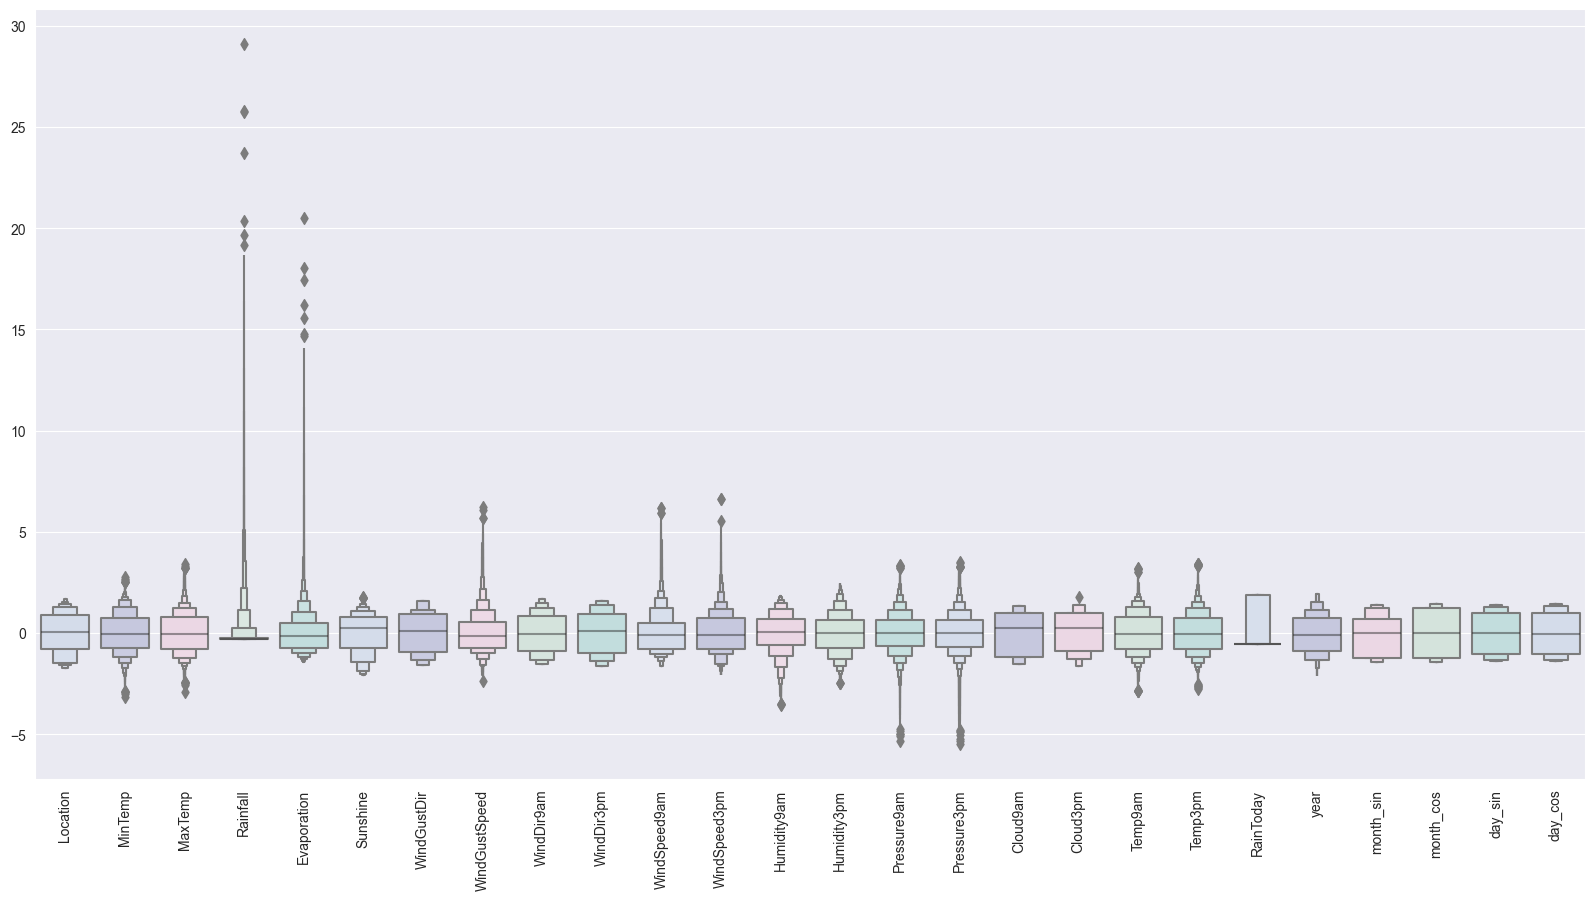

In [28]:
#Detecting outliers
#looking at the scaled features
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(20, 10))
sns.boxenplot(data=features, palette=colours)
plt.xticks(rotation=90)
plt.show()

In [29]:
#full data for
features["RainTomorrow"] = target

#Dropping with outlier

features = features[(features["MinTemp"] < 2.3) & (features["MinTemp"] > -2.3)]
features = features[(features["MaxTemp"] < 2.3) & (features["MaxTemp"] > -2)]
features = features[(features["Rainfall"] < 4.5)]
features = features[(features["Evaporation"] < 2.8)]
features = features[(features["Sunshine"] < 2.1)]
features = features[(features["WindGustSpeed"] < 4) & (features["WindGustSpeed"] > -4)]
features = features[(features["WindSpeed9am"] < 4)]
features = features[(features["WindSpeed3pm"] < 2.5)]
features = features[(features["Humidity9am"] > -3)]
features = features[(features["Humidity3pm"] > -2.2)]
features = features[(features["Pressure9am"] < 2) & (features["Pressure9am"] > -2.7)]
features = features[(features["Pressure3pm"] < 2) & (features["Pressure3pm"] > -2.7)]
features = features[(features["Cloud9am"] < 1.8)]
features = features[(features["Cloud3pm"] < 2)]
features = features[(features["Temp9am"] < 2.3) & (features["Temp9am"] > -2)]
features = features[(features["Temp3pm"] < 2.3) & (features["Temp3pm"] > -2)]

features.shape

(50816, 27)

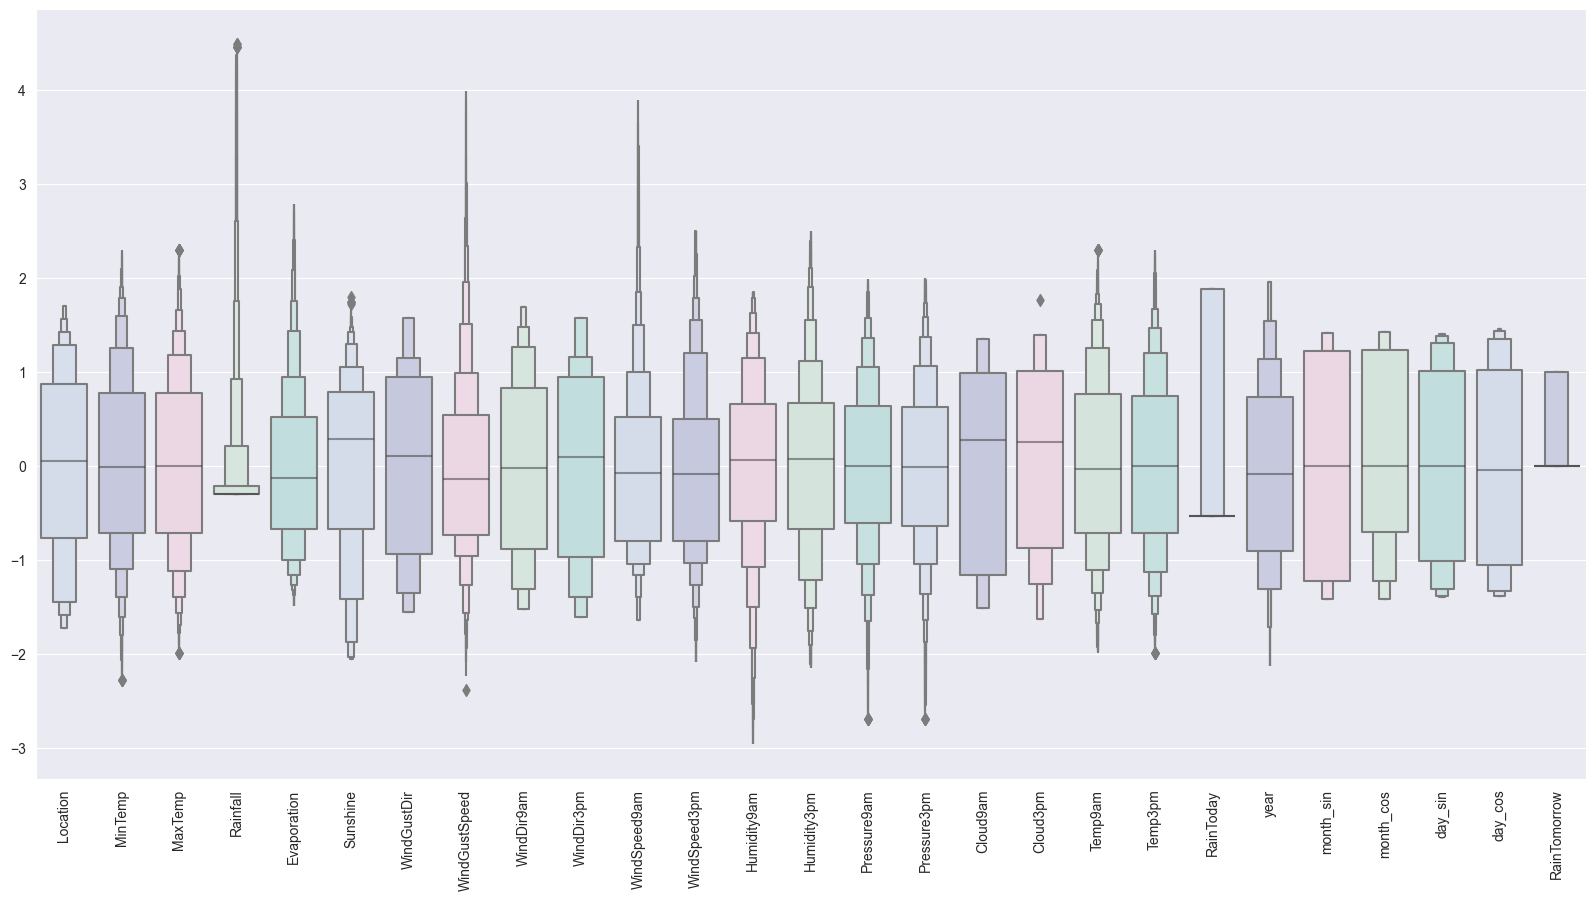

In [30]:
#looking at the scaled features without outliers

plt.figure(figsize=(20, 10))
sns.boxenplot(data=features, palette=colours)
plt.xticks(rotation=90)
plt.show()

In [31]:
X = features.drop(["RainTomorrow"], axis=1)
y = features["RainTomorrow"]

# Splitting test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X.shape

(50816, 26)

In [33]:

#Early stopping
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu', input_dim = 26))
model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
opt = Adam(learning_rate=0.00009)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

# Train the ANN
history = model.fit(X_train, y_train, batch_size = 32, epochs = 150, callbacks=[early_stopping], validation_split=0.2)

Epoch 1/150


d:\study\python\venv\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


1017/1017 [==============================] - 3s 2ms/step - loss: nan - accuracy: 0.2158 - val_loss: nan - val_accuracy: 0.2167
Epoch 2/150
1017/1017 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.2158 - val_loss: nan - val_accuracy: 0.2167
Epoch 3/150
1017/1017 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.2158 - val_loss: nan - val_accuracy: 0.2167
Epoch 4/150
1017/1017 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.2158 - val_loss: nan - val_accuracy: 0.2167
Epoch 5/150
1017/1017 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.2158 - val_loss: nan - val_accuracy: 0.2167
Epoch 6/150
1017/1017 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.2158 - val_loss: nan - val_accuracy: 0.2167
Epoch 7/150
1017/1017 [==============================] - 2s 2ms/step - loss: nan - accuracy: 0.2158 - val_loss: nan - val_accuracy: 0.2167
Epoch 8/150
1017/1017 [================

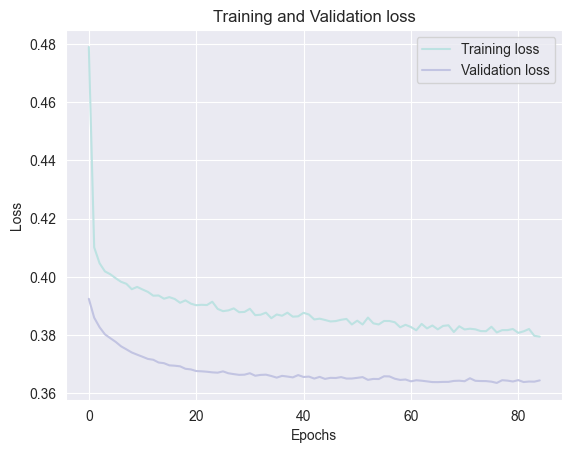

In [30]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#BDE2E2", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']], "#C2C4E2", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

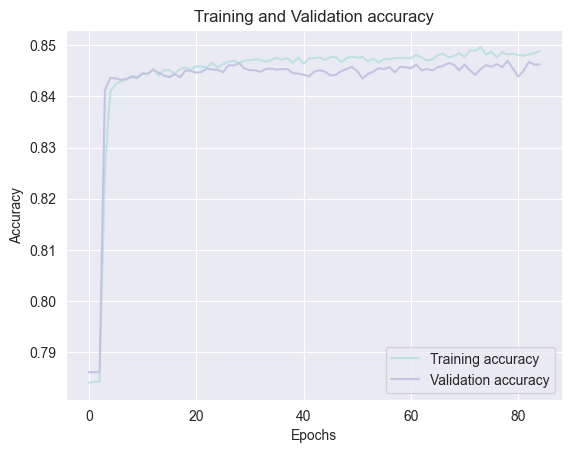

In [31]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
# Predicting the test set results
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)

798/798 [==============================] - 1s 1ms/step


<AxesSubplot: >

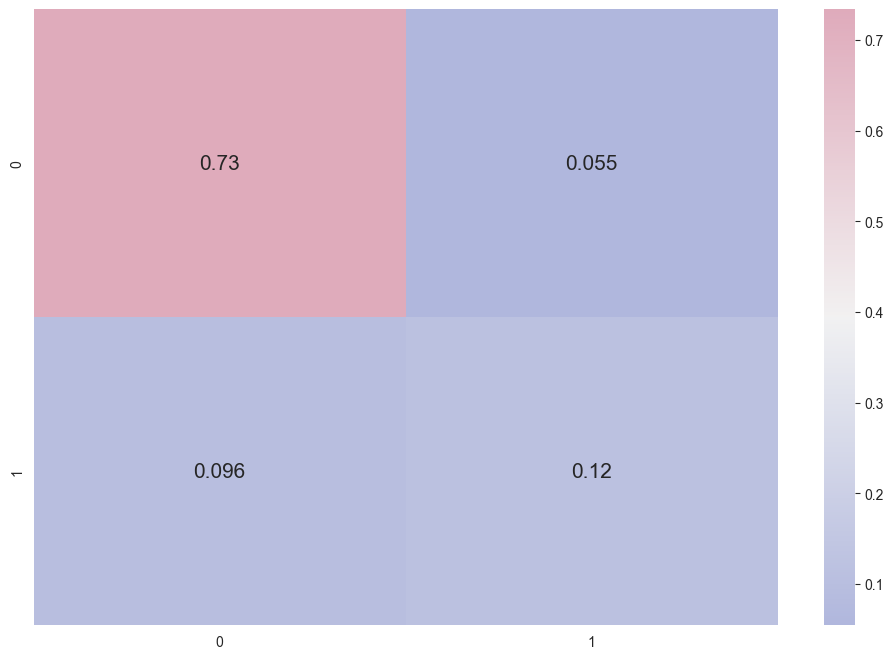

In [33]:
# confusion matrix
cmap1 = sns.diverging_palette(260, -10, s=50, l=75, n=5, as_cmap=True)
plt.subplots(figsize=(12, 8))
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix / np.sum(cf_matrix), cmap=cmap1, annot=True, annot_kws={'size': 15})

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     20110
           1       0.68      0.54      0.60      5398

    accuracy                           0.85     25508
   macro avg       0.78      0.74      0.76     25508
weighted avg       0.84      0.85      0.84     25508

